<a href="https://colab.research.google.com/github/jurados/NotesPytorch/blob/main/%5B04%5D_Training_Deep_Neural_Networks_on_a_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.youtube.com/watch?v=vo_fUOk-IKk&list=PLWKjhJtqVAbm3T2Eq1_KgloC7ogdXxdRa

# 04 Training Deep Neural Networks on a GPU

In [ ]:
import torch
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

In [ ]:
dataset = MNIST(root='./data', download=True, transform=ToTensor())

In [ ]:
val_size = 10000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(50000, 10000)

In [ ]:
batch_size = 128
train_loader = DataLoader(dataset, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(dataset, batch_size*2, num_workers=2, pin_memory=True)

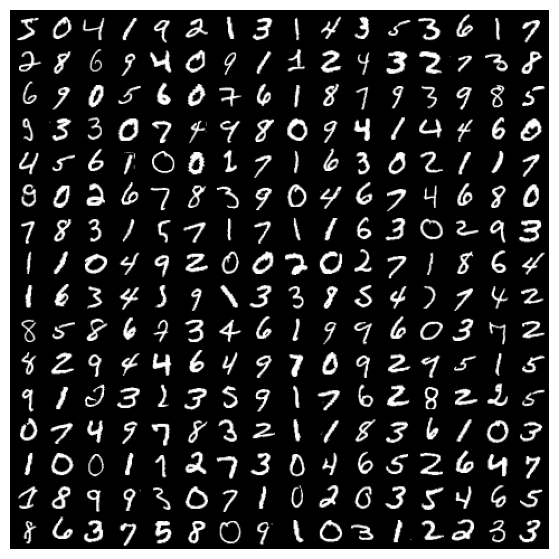

In [ ]:
for images, _ in train_loader:
  plt.figure(figsize=(10,7))
  plt.axis(False)
  plt.imshow(make_grid(images,nrow=16).permute((1,2,0)))
  break

In [ ]:
class MNISTModelV0(nn.Module):
    """Feedfoward neural network with 1 hidden layer"""
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()
        # hidden layer
        self.linear1 = nn.Linear(in_features=in_size, out_features=hidden_size)
        # output layer
        self.linear2 = nn.Linear(in_features=hidden_size, out_features=out_size)

    def forward(self, xb):
        # Flatten the image tensors
        xb = xb.view(xb.size(0), -1)
        # Get intermediate outputs using hidden layer
        out = self.linear1(xb)
        # Apply activation function
        out = F.relu(out)
        # Get predictions using output layer
        out = self.linear2(out)
        return out

    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

# out = (X @ W1 + b1) @ W2 + b2 = X @ W1 @ W2 + b1 @ W2 + b2 = X @ (W1 @ W2) + b1 @ W2 + b2 = X @ (W1 @ W2) + (b1 @ W2 + b2) = X @ W3 + b3

In [ ]:
# Creat a model that contains a hiddenlayers with 32 activations.

input_size = 784
hidden_size = 32
num_classes = 10

In [ ]:
model = MNISTModelV0(input_size, hidden_size = hidden_size, out_size=num_classes)
model

MNISTModelV0(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

In [ ]:
for t in model.parameters():
  print(t.shape)

torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


In [ ]:
for images, labels in train_loader:
  outputs = model(images)
  loss = F.cross_entropy(outputs, labels)
  print('Loss', loss.item())
  break

print(f'Outputs shape: {outputs.shape}')
print(f'Sample outputs:\n {outputs[:2].data}')

Loss 2.3142497539520264
Outputs shape: torch.Size([256, 10])
Sample outputs:
 tensor([[-0.2762,  0.2921,  0.0890, -0.0008,  0.0869,  0.0657, -0.1248, -0.1083,
          0.0007,  0.0522],
        [-0.1841,  0.2425,  0.1973, -0.1465, -0.0039,  0.0459, -0.2037,  0.0698,
          0.0873, -0.1253]])


## 4.1 Using a GPU

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [ ]:
for images, labels in train_loader:
  print(images.shape)
  images = images.to(device)
  print(images.device)
  break

torch.Size([256, 1, 28, 28])
cpu


In [ ]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

## 4.2 Training the model

In [ ]:
def evaluate(model, val_loader):
    """Evaluate the model's performance on the validation set"""
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    """Train the model using gradient descent"""
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
model = MNISTModelV0(input_size, hidden_size=hidden_size, out_size=num_classes)
to_device(model, device)

MNISTModelV0(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

In [ ]:
history = [evaluate(model, val_loader)]
history

[{'val_loss': 2.32256817817688, 'val_acc': 0.09629321843385696}]

In [ ]:
history += fit(5, 0.5, model, train_loader, val_loader)

Epoch [0], val_loss: 0.2109, val_acc: 0.9360
Epoch [1], val_loss: 0.1371, val_acc: 0.9603
Epoch [2], val_loss: 0.1161, val_acc: 0.9655
Epoch [3], val_loss: 0.0939, val_acc: 0.9730
Epoch [4], val_loss: 0.0828, val_acc: 0.9761


In [ ]:
history += fit(5, 0.1, model, train_loader, val_loader)

Epoch [0], val_loss: 0.0699, val_acc: 0.9806
Epoch [1], val_loss: 0.0668, val_acc: 0.9812
Epoch [2], val_loss: 0.0651, val_acc: 0.9820
Epoch [3], val_loss: 0.0640, val_acc: 0.9818
Epoch [4], val_loss: 0.0620, val_acc: 0.9828


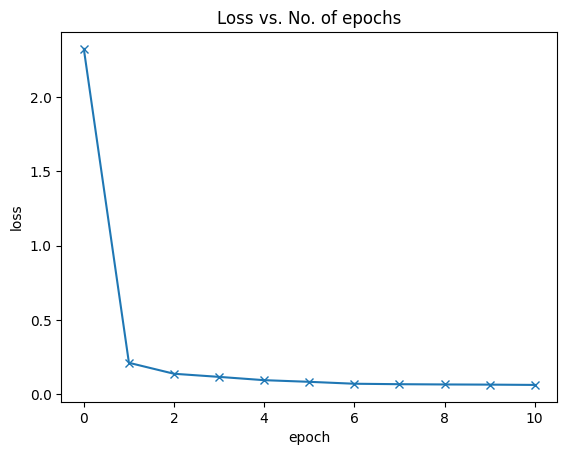

In [ ]:
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

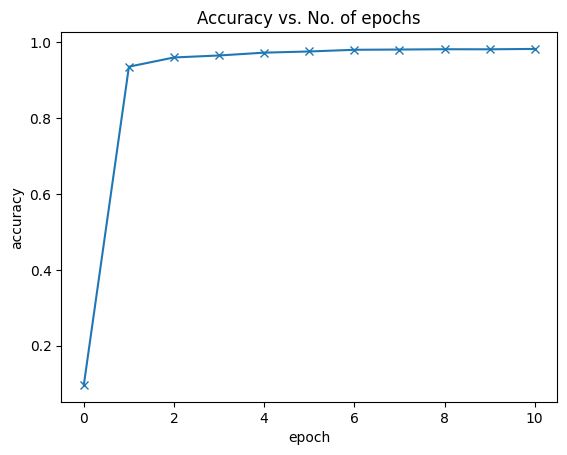

In [ ]:
accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

## 4.3 Testing with individual images

In [ ]:
# Define test dataset
test_dataset = MNIST(root='data/',
                     train=False,
                     transform=ToTensor())

In [ ]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

Label: 7 , Predicted: 7


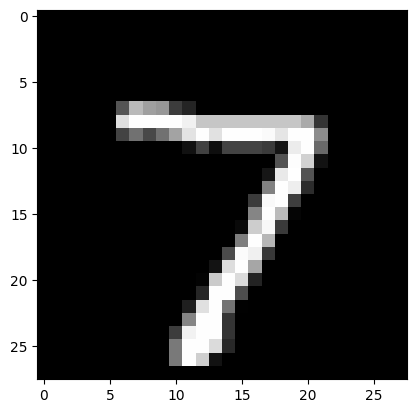

In [ ]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 2 , Predicted: 2


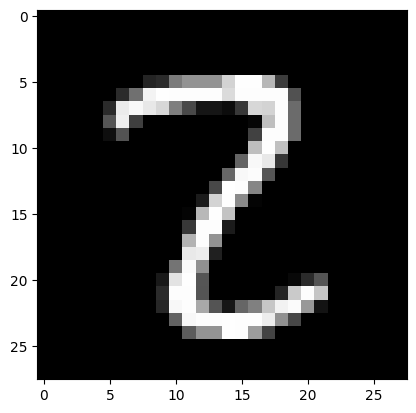

In [ ]:
img, label = test_dataset[1839]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

In [ ]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size=256), device)
result = evaluate(model, test_loader)
result

{'val_loss': 0.09492901712656021, 'val_acc': 0.9701172113418579}